# I. Data Collection

## I.1. Extracting SpaceX API

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

Next, define several functions that will help to extract information from the API

In [2]:
# Extract rocket column and append the data to the list, we need to know the booster name
def getBoosterVersions(data):
  for x in data['rocket']:
    if x:
      response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
      boosterVersion.append(response['name'])

# Extract launchpad column, to know the name of launch site, its longitude and latitude
def getLaunchSide(data):
  for x in data['launchpad']:
    if x :
      response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
      longitude.append(response['longitude'])
      latitude.append(response['latitude'])
      launchSite.append(response['name'])

# Extract payload column to learn mass of the payload, and orbit that is going to
def getPayloadData(data):
  for load in data['payloads']:
    if load:
      response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
      payloadMass.append(response['mass_kg'])
      orbit.append(response['orbit'])

# Extract cores column to learn the outcome n type of landing, number of flights with that core, and whether core, legs, landing pad are used
# the block of the core which is a number used to separate version of cores, number of times this spefic core has been reused, and serial of the core
def getCoreData(data):
  for core in data['cores']:
    if core['core'] != None:
      response = requests.get("https://api.spacexdata.com/v4/cores/" + core['core']).json()
      block.append(response['block'])
      reusedCount.append(response['reuse_count'])
      serial.append(response['serial'])
    else:
      block.append(None)
      reusedCount.append(None)
      serial.append(None)

    # Extract the data, in the GENERAL API, not on the specified API link on the specified response variabel
    outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
    flights.append(core['flight'])
    gridFins.append(core['gridfins'])
    reused.append(core['reused'])
    legs.append(core['legs'])
    landingPad.append(core['landpad'])

Start request rocket launch data

In [3]:
Response = requests.get("https://api.spacexdata.com/v4/launches/past")

Task 1 : Request n parse SpaxeX Laun Data

In [4]:
# For this project, we will use the static response to make the results more consistent
staticUrl ='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
Response.status_code

200

In [5]:
# Convert the json to a pandas dataframe
Response = requests.get(staticUrl)
df = pd.json_normalize(Response.json()) # .json() untuk mengubah response menjadi dictionary python
df.head()

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,True,None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


In [6]:
# Most the data are identification numbers n no information about the datatset,
# So, we will use the more detailed API to get information abt the launches using IDs given for each launch

# Take the subset of the dataframe
df = df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# remove rows with  MULTIPLE CORE VALUES, cuz those are falcon rockets with 2 extra boosters
# and also there are rows that have multiple payloads in single rocket that we will remove
# ex. remove the ['a','b']
df = df[df['cores'].map(len) == 1] # .map() to apply the function to each element on the column
df = df[df['payloads'].map(len) == 1]

# Convert the single value on the list, to only the value itself (remove the list).
# Ex, from ['a'] to 'a'
df['cores'] = df['cores'].map(lambda x:x[0])
df['payloads'] = df['payloads'].map(lambda x:x[0])

# Convert the dateUtc to a datetime datatype, then extracting the date leaving the time
# Ex, from '2024-10-12T15:30:00Z' to 2024-101-12
df['date'] = pd.to_datetime(df['date_utc']).dt.date

# Restrict n filter the dates of the launches which 2020-11-13, MUST for datetime (datetime.date) datatype
df = df[df['date'] <= datetime.date(2020, 11, 13)]

In [7]:
# Create a list to store the data from the request to create a new dataframe
boosterVersion = []
payloadMass = []
orbit = []
launchSite = []
outcome = []
flights = []
gridFins = []
reused = []
legs = []
landingPad = []
block = []
reusedCount = []
serial = []
longitude = []
latitude = []

In [8]:
# Apply the defined function to get the values to the list
getBoosterVersions(df)
getLaunchSide(df)
getPayloadData(df)
getCoreData(df)

boosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [9]:
Dict = {
    'FlightNumber': list(df['flight_number']),
    'Date': list(df['date']),
    'BoosterVersion': boosterVersion,
    'PayloadMass': payloadMass,
    'Orbit': orbit,
    'LaunchSite': launchSite,
    'Outcome': outcome,
    'Flights': flights,
    'GridFins': gridFins,
    'Reused': reused,
    'Legs': legs,
    'LandingPad': landingPad,
    'Block': block,
    'ReusedCount': reusedCount,
    'Serial': serial,
    'Longitude': longitude,
    'Latitude': latitude
}

In [10]:
# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(Dict)
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    94 non-null     int64  
 1   Date            94 non-null     object 
 2   BoosterVersion  94 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           94 non-null     object 
 5   LaunchSite      94 non-null     object 
 6   Outcome         94 non-null     object 
 7   Flights         94 non-null     int64  
 8   GridFins        94 non-null     bool   
 9   Reused          94 non-null     bool   
 10  Legs            94 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     94 non-null     int64  
 14  Serial          94 non-null     object 
 15  Longitude       94 non-null     float64
 16  Latitude        94 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [12]:
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,94.000000,88.000000,94.000000,90.000000,94.000000,94.000000,94.000000
mean,54.202128,5919.165341,1.755319,3.500000,3.053191,-75.553302,28.581782
std,30.589048,4909.689575,1.197544,1.595288,4.153938,53.391880,4.639981
min,1.000000,20.000000,1.000000,1.000000,0.000000,-120.610829,9.047721
25%,28.250000,2406.250000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,52.500000,4414.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,81.500000,9543.750000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,106.000000,15600.000000,6.000000,5.000000,13.000000,167.743129,34.632093


Task 2 : Filter dataframe to only include falcon9 launches

In [13]:
dfFalcon9 = df[df['BoosterVersion'] == 'Falcon 9']

# change the Flight number values into new id values for only the falcon9 versions
dfFalcon9.loc[:, 'FlightNumber'] = list(range(1, dfFalcon9.shape[0] + 1))
dfFalcon9.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [14]:
dfFalcon9['LandingPad'].isna().sum()

np.int64(26)

In [15]:
# Dealing with the missing values
display(dfFalcon9['PayloadMass'].isnull().sum())

dfFalcon9['PayloadMass'] = dfFalcon9['PayloadMass'].fillna(dfFalcon9['PayloadMass'].mean())
display(dfFalcon9['PayloadMass'].isnull().sum())

np.int64(5)

<ipython-input-15-0d63db15677e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFalcon9['PayloadMass'] = dfFalcon9['PayloadMass'].fillna(dfFalcon9['PayloadMass'].mean())


np.int64(0)

## I.2. Extracting Data Using Webscraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

Link Source : https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches


More specifically, the launch records are stored in a HTML table shown below:
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


In [16]:
import sys
from bs4 import BeautifulSoup
import re
import unicodedata

In [17]:
# There will be some functions that help us to scrap the HTML table
def date_time(cells):
  # This function is to extract each value on table on iteration -> convert to a list -> remove the space with .strip() -? choose the 1st and 2nd element [0:2]
  return [date_time.strip() for date_time in list(cells.strings)][0:2]

def booster_version(cells):
  # Extract each value and its index through enumerated iteration -> take the even index -> cut the last element -> combine the element to a string -> return output
  out = ''.join([booster_version for i, booster_version in enumerate(cells.strings) if i%2==0][0:-1])
  return out

def landing_status(cells):
  # extract each value on table through iteration -> change text to a list -> take the 1st element [0] -> return
  out = [i for i in cells.strings][0]
  return out

def get_mass(cells):
  # Extract text from tabel, and normalize the unicode word (ex. 1/2(yg cuman 1 karakter) jd 1/2)
  # Then delete the space on the first and last with strip()
  mass = unicodedata.normalize("NFKD", cells.text).strip()

  # if the text exist, then find the "kg" word
  if mass:
    mass.find("kg")
    # Extract the substring value from beginning until 2 index after kg string founded
    # To ensure that the extracted text only until kg, not the character after it
    new_mass = mass[0:mass.find("kg")+2]
  else:
    # if in a tabel there are not "kg" unit, then mass = 0
    new_mass = 0
  return new_mass

def extract_column_from_header(row):
  # Check is there element br, a, or sup in html header
  # If yes, then we extract/delete all of it
  if (row.br):
    row.br.extract()
  if row.a:
    row.a.extract()
  if row.sup:
    row.sup.extract()

  # Take all elements on row contents,
  column_name = " ".join(row.contents)

  if not(column_name.strip().isdigit()):
    column_name = column_name.strip()
    return column_name

TASK 1 : Request the Falcon9 Launch Wikipage from its URL

In [18]:
# we use static url, updated on 9th june 2021
static = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [19]:
# request the html page as http response
response = requests.get(static)
response.status_code

200

In [20]:
# Create a beautiful object
soup = BeautifulSoup(response.content)

In [21]:
# Verify the object is created
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

TASK 2. Extract all column n variable names from HTML table header

In [22]:
html_tables = soup.find_all("table")

In [23]:
# Print third label, and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

In [24]:
column_names = []

for column in first_launch_table.find_all("th"):
  name = extract_column_from_header(column)
  if name is not None and len(name) > 0:
    column_names.append(name)

column_names

['Flight No.',
 'Date and time ( )',
 'Launch site',
 'Payload',
 'Payload mass',
 'Orbit',
 'Customer',
 'Launch outcome']

TASK 3: Create a dataframe by parsing the launch of HTML Tables

In [25]:
# Next, we will create empty dictionary with keys from the extracted column names


launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [26]:
# Next, we will fill up the launch_dict with launch records from the table rows
# Usually, HTML Tables in wiki pages contain unexpected annotations, other types of noises, missing values n inconsistent formatting

extracted_row = 0
# Next, extract each table
for table_number, table in enumerate(soup.find_all("table")):
  # Next, get the table row
  for rows in table.find_all("tr"):
    # Checking to see if the first table heading is a number corresponding to launch a number
    if rows.th:
      if rows.th.string:
        flight_number = rows.th.string.strip()
        flag = flight_number.isdigit()
    else:
      flag = False
    # get the table element
    row = rows.find_all("td")
    # If it is number that save cells in a dictionary
    if flag:
      extracted_row += 1
      # 1. Flight number value
      launch_dict['Flight No.'].append(flight_number)
      print(flight_number)
      datetimelist = date_time(row[0])
      # 2. Date value
      date = datetimelist[0].strip(',')
      launch_dict['Date'].append(date)
      print(date)
      # 3. Time value
      time = datetimelist[1]
      launch_dict['Time'].append(time)
      print(time)
      # 4. Booster version
      bv = booster_version(row[1])
      if not(bv):
        bv = row[1].a.string
      launch_dict['Version Booster'].append(bv)
      print(bv)
      # 5. Launch site
      launch_site = row[2].a.string
      launch_dict['Launch site'].append(launch_site)
      print(launch_site)
      # 6. Payload
      payload = row[3].a.string
      launch_dict['Payload'].append(payload)
      print(payload)
      # 7. Payload mass
      payload_mass = get_mass(row[4])
      launch_dict['Payload mass'].append(payload_mass)
      print(payload_mass)
      # 8. Orbit
      orbit = row[5].a.string
      launch_dict['Orbit'].append(orbit)
      print(orbit)
      # 9. Customer
      customer = row[6].a.string if row[6].a else None
      launch_dict['Customer'].append(customer)
      print(customer)
      # 10. Launch outcome
      launch_outcome = list(row[7].strings)[0]
      launch_dict['Launch outcome'].append(launch_outcome)
      print(launch_outcome)
      # 11. Booster landing
      booster_landing = landing_status(row[8])
      launch_dict['Booster landing'].append(booster_landing)
      print(booster_landing)

1
4 June 2010
18:45
F9 v1.07B0003.18
CCAFS
Dragon Spacecraft Qualification Unit
0
LEO
SpaceX
Success

Failure
2
8 December 2010
15:43
F9 v1.07B0004.18
CCAFS
Dragon
0
LEO
NASA
Success
Failure
3
22 May 2012
07:44
F9 v1.07B0005.18
CCAFS
Dragon
525 kg
LEO
NASA
Success
No attempt

4
8 October 2012
00:35
F9 v1.07B0006.18
CCAFS
SpaceX CRS-1
4,700 kg
LEO
NASA
Success

No attempt
5
1 March 2013
15:10
F9 v1.07B0007.18
CCAFS
SpaceX CRS-2
4,877 kg
LEO
NASA
Success

No attempt

6
29 September 2013
16:00
F9 v1.17B10038
VAFB
CASSIOPE
500 kg
Polar orbit
MDA
Success
Uncontrolled
7
3 December 2013
22:41
F9 v1.1
CCAFS
SES-8
3,170 kg
GTO
SES
Success
No attempt
8
6 January 2014
22:06
F9 v1.1
CCAFS
Thaicom 6
3,325 kg
GTO
Thaicom
Success
No attempt
9
18 April 2014
19:25
F9 v1.1
Cape Canaveral
SpaceX CRS-3
2,296 kg
LEO
NASA
Success

Controlled
10
14 July 2014
15:15
F9 v1.1
Cape Canaveral
Orbcomm-OG2
1,316 kg
LEO
Orbcomm
Success
Controlled
11
5 August 2014
08:00
F9 v1.1
Cape Canaveral
AsiaSat 8
4,535 kg
GTO
As

In [27]:
dfhtml = pd.DataFrame({
    key : pd.Series(value) for key, value in launch_dict.items()
})

dfhtml.head(5)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10


# II. Data Wrangling

In [28]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [29]:
# Calculate the missing values percentage on each attributes
df.isnull().sum()/len(df)*100

,0
FlightNumber,0.000000
Date,0.000000
BoosterVersion,0.000000
PayloadMass,0.000000
Orbit,0.000000
LaunchSite,0.000000
Outcome,0.000000
Flights,0.000000
GridFins,0.000000
Reused,0.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

TASK 1 : Calculate the number of launches on each site

In [31]:
df['LaunchSite'].value_counts()

,count
LaunchSite,
CCAFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


TASK 2 : Calculate the Number and Occurence of Each Orbit

In [32]:
df['Orbit'].value_counts()

,count
Orbit,
GTO,27
ISS,21
VLEO,14
PO,9
LEO,7
SSO,5
MEO,3
HEO,1
ES-L1,1


TASK 3 : Calculate the Number and Occurence of Mission Outcome of The Orbits

In [33]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


In [34]:
for i, outcome in enumerate(landing_outcomes.keys()):
  print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [35]:
# create a set of outcomes where the second stage fail to land
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

TASK 4 : Create a landing outcome label from outcome column

In [36]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in df['Outcome']]
landing_class[0:5]

[0, 0, 0, 0, 0]

In [37]:
df['Class'] = landing_class
df[['Class']].head(10)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1
8,0
9,0


In [38]:
df['Class'].value_counts()

,count
Class,
1,60
0,30


# III. Exploratory Data Analysis

## III.1. EDA Using SQL

In [39]:
%reload_ext sql
import csv, sqlite3, prettytable
prettytable.DEFAULT = 'DEFAULT'

connection = sqlite3.connect("ExerciseDB1.db")
cur = connection.cursor()

%sql sqlite:///ExerciseDB1.db

In [40]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("spacexTable", connection, if_exists='replace', index=False,method="multi")

101

In [41]:
# Remove the blank rows from the tabel
%sql DROP TABLE IF EXIST spacexTable
%sql CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTABLE WHERE DATE IS NOT NULL
%sql SELECT * FROM SPACEXTABLE LIMIT 3

 * sqlite:///ExerciseDB1.db
(sqlite3.OperationalError) near "EXIST": syntax error
[SQL: DROP TABLE IF EXIST spacexTable]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite:///ExerciseDB1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTABLE WHERE DATE IS NOT NULL]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
 * sqlite:///ExerciseDB1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt


TASK 1 : Display names of unique launch sites in the space mission

In [42]:
%sql SELECT DISTINCT(LAUNCH_SITE) FROM SPACEXTABLE

 * sqlite:///ExerciseDB1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


TASK 2 : Display 5 records where launch sites begin with the string "CCA"

In [43]:
%sql SELECT * FROM SPACEXTABLE WHERE LAUNCH_SITE LIKE 'CCA%' LIMIT 5

 * sqlite:///ExerciseDB1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


TASK 3 : Display total payload mass carried by boosters launched by NASA

In [44]:
%sql SELECT BOOSTER_VERSION, SUM(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE CUSTOMER LIKE 'NASA%' GROUP BY BOOSTER_VERSION

 * sqlite:///ExerciseDB1.db
Done.


Booster_Version,SUM(PAYLOAD_MASS__KG_)
F9 B4 B1039.2,2647
F9 B4 B1039.1,3310
F9 B4 B1045.1,362
F9 B4 B1045.2,2697
F9 B5 B1046.4,12050
F9 B5 B1056.2,2268
F9 B5 B1058.4,2972
F9 B5 B1059.2,1977
F9 B5B1050,2500
F9 B5B1051.1,12055


TASK 4 : Display Average Payload Mass Carried by Booster Version F9 v1.1

In [45]:
%sql SELECT BOOSTER_VERSION, AVG(PAYLOAD_MASS__KG_) FROM SPACEXTABLE WHERE BOOSTER_VERSION LIKE 'F9 V1.1%' GROUP BY BOOSTER_VERSION

 * sqlite:///ExerciseDB1.db
Done.


Booster_Version,AVG(PAYLOAD_MASS__KG_)
F9 v1.1,2928.4
F9 v1.1 B1003,500.0
F9 v1.1 B1010,2216.0
F9 v1.1 B1011,4428.0
F9 v1.1 B1012,2395.0
F9 v1.1 B1013,570.0
F9 v1.1 B1014,4159.0
F9 v1.1 B1015,1898.0
F9 v1.1 B1016,4707.0
F9 v1.1 B1017,553.0


Task 5 : List the date when the first succesful landing outcome in ground pad was achieved

In [46]:
%sql SELECT * FROM SPACEXTABLE WHERE LANDING_OUTCOME like "Success (ground pad)" order by date asc limit 1

 * sqlite:///ExerciseDB1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2015-12-22,1:29:00,F9 FT B1019,CCAFS LC-40,OG2 Mission 2 11 Orbcomm-OG2 satellites,2034,LEO,Orbcomm,Success,Success (ground pad)


TASK 6 : List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [47]:
%sql SELECT BOOSTER_VERSION FROM SPACEXTABLE WHERE LANDING_OUTCOME LIKE "Success (drone ship)" AND PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000

 * sqlite:///ExerciseDB1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


TASK 7 : List the total number of successful and failure mission outcomes

In [48]:
%sql SELECT MISSION_OUTCOME, COUNT(MISSION_OUTCOME) FROM SPACEXTABLE GROUP BY MISSION_OUTCOME

 * sqlite:///ExerciseDB1.db
Done.


Mission_Outcome,COUNT(MISSION_OUTCOME)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


TASK 8 : List the names of Booster_Versions which have carried the maximum payload mass, use a subquery

In [49]:
%sql SELECT BOOSTER_VERSION, PAYLOAD_MASS__KG_ FROM SPACEXTABLE WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE) GROUP BY BOOSTER_VERSION

 * sqlite:///ExerciseDB1.db
Done.


Booster_Version,PAYLOAD_MASS__KG_
F9 B5 B1048.4,15600
F9 B5 B1048.5,15600
F9 B5 B1049.4,15600
F9 B5 B1049.5,15600
F9 B5 B1049.7,15600
F9 B5 B1051.3,15600
F9 B5 B1051.4,15600
F9 B5 B1051.6,15600
F9 B5 B1056.4,15600
F9 B5 B1058.3,15600


TASK 9 : List the records which will display the month names, failure landing_outcomes in drone ship, booster versions, launch_site for the months in year 2015

In [50]:
%sql SELECT substr(Date, 6,2) as MONTH, LANDING_OUTCOME, BOOSTER_VERSION, LAUNCH_SITE FROM SPACEXTABLE WHERE LANDING_OUTCOME LIKE "Failure (drone ship)" AND substr(DATE,0,5)= '2015'

 * sqlite:///ExerciseDB1.db
Done.


MONTH,Landing_Outcome,Booster_Version,Launch_Site
01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


TASK 10 : Rank the count of landing outcomes (such as Failure (drone ship)) between the date 2010-06-04 and 2017-03-20 in descending order

In [51]:
%sql SELECT LANDING_OUTCOME, COUNT(*) AS count, RANK() OVER (ORDER BY COUNT(*) DESC) AS Ranking FROM SPACEXTABLE WHERE DATE BETWEEN '2010-06-04' AND '2017-03-20' GROUP BY LANDING_OUTCOME ORDER BY count DESC;

 * sqlite:///ExerciseDB1.db
Done.


Landing_Outcome,count,Ranking
No attempt,10,1
Success (drone ship),5,2
Failure (drone ship),5,2
Success (ground pad),3,4
Controlled (ocean),3,4
Uncontrolled (ocean),2,6
Failure (parachute),2,6
Precluded (drone ship),1,8


## III.2. EDA Using Pandas, MatPlotlib and Seaborn

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


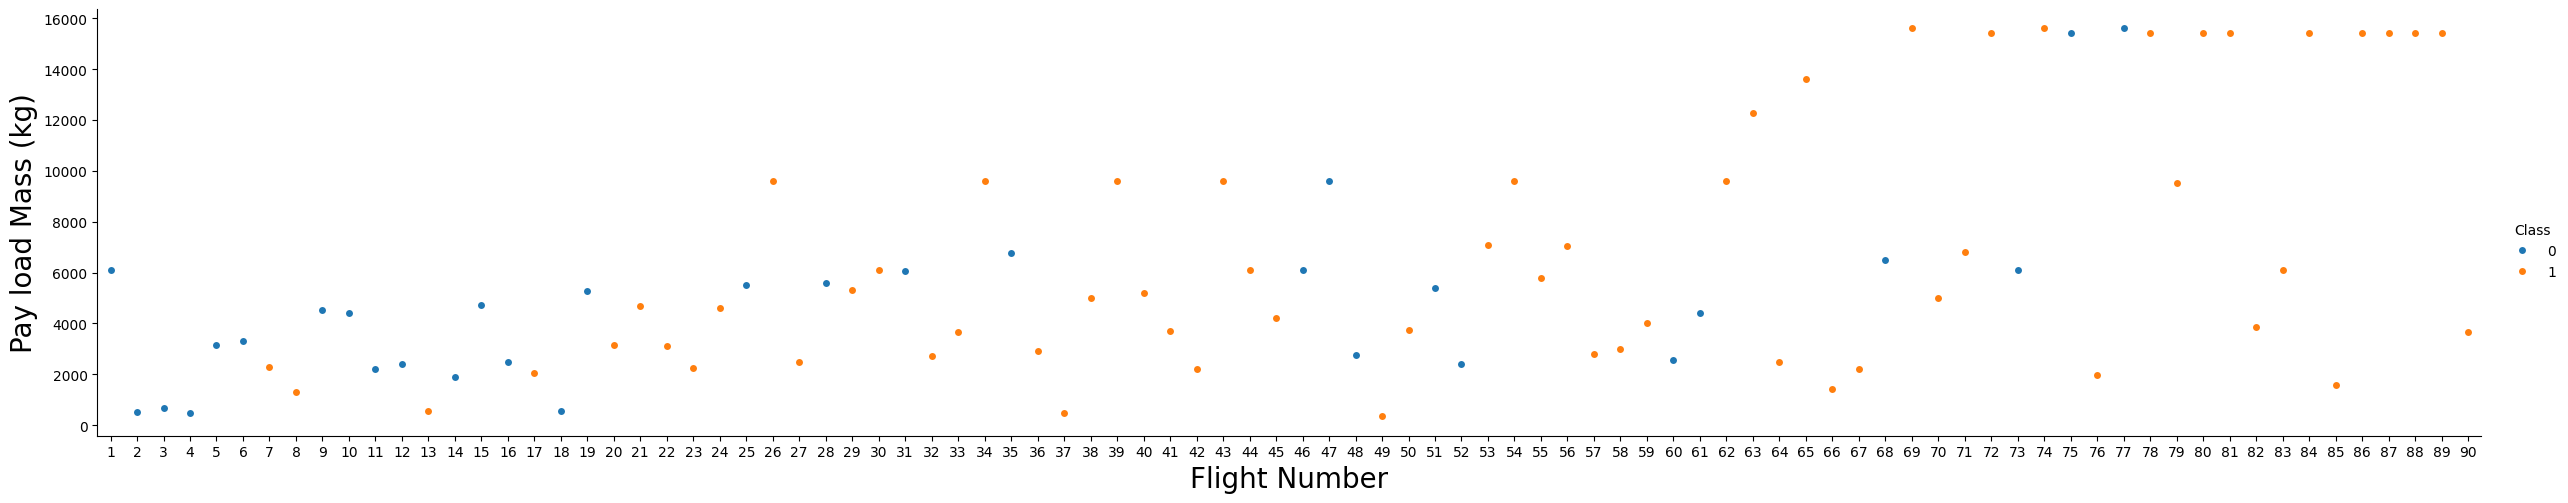

In [54]:
# Plot the flight number vs payload mass
sns.catplot(y='PayloadMass', x='FlightNumber', hue = 'Class', data = df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()


Task 1 : Visualize the Relationship between Flight Number and Launch Site

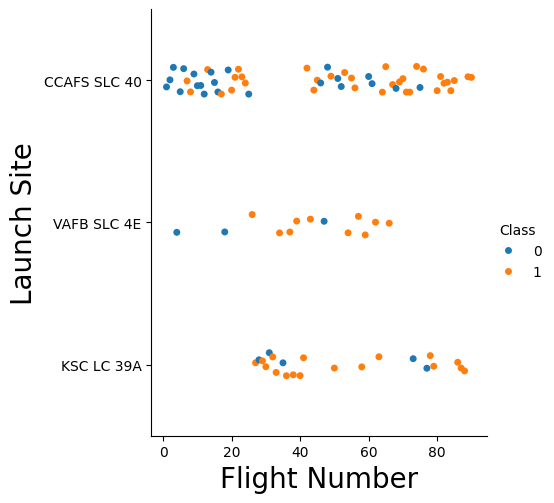

In [55]:
sns.catplot(x='FlightNumber', y='LaunchSite', hue='Class', data = df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

TASK 2: Visualize the relationship between Payload and Launch Site


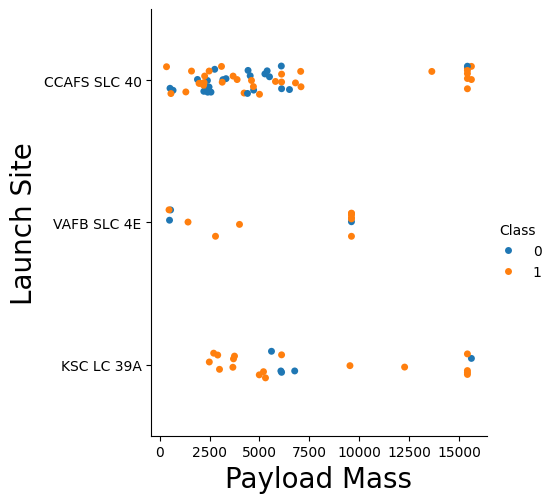

In [56]:
sns.catplot(x='PayloadMass', y='LaunchSite', hue='Class', data = df)
plt.xlabel("Payload Mass",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

TASK 3 : Visualize the relationship between success rate of each orbit type

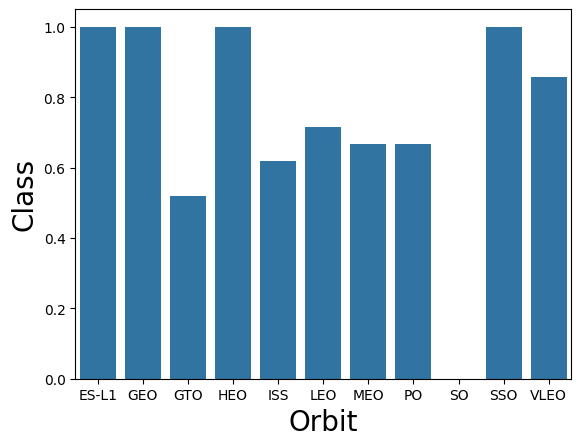

In [57]:
dfgrouped = df.groupby(['Orbit'])['Class'].mean().reset_index()
sns.barplot(x='Orbit', y='Class', data = dfgrouped)
plt.xlabel("Orbit",fontsize=20)
plt.ylabel("Class",fontsize=20)
plt.show()

Task 4 : Visualize Relationship between FlightNumber and Orbit Type

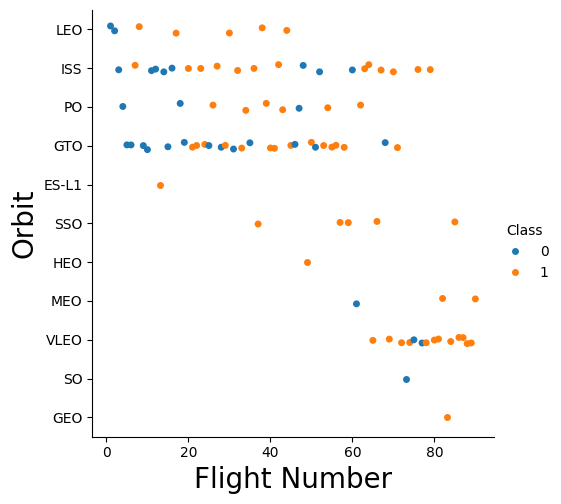

In [58]:
sns.catplot(x='FlightNumber', y='Orbit', hue='Class', data = df)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

On the LEO, the success number related to the flight number

TASK 5 : Visualize the relationship between Payload and Orbit Type

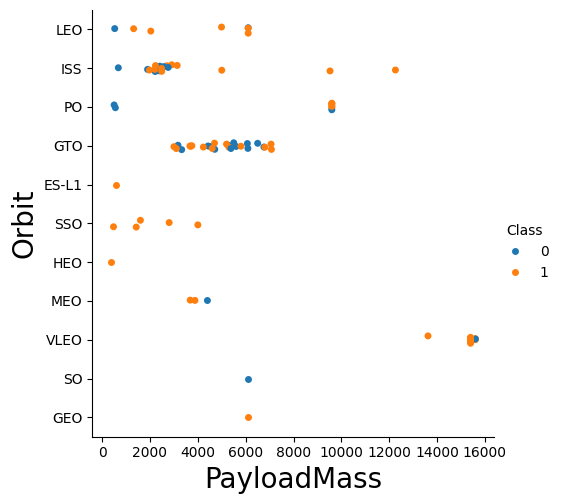

In [59]:
sns.catplot(x='PayloadMass', y='Orbit', hue='Class', data = df)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

TASK 6 : Visualize the launch successs yearly trend

In [60]:
# Function to extract year from the date
year = []
def extractYear(data):
  for i in df['Date']:
    year.append(i.split('-')[0])
  return year

extractYear(df)
df['year'] = year

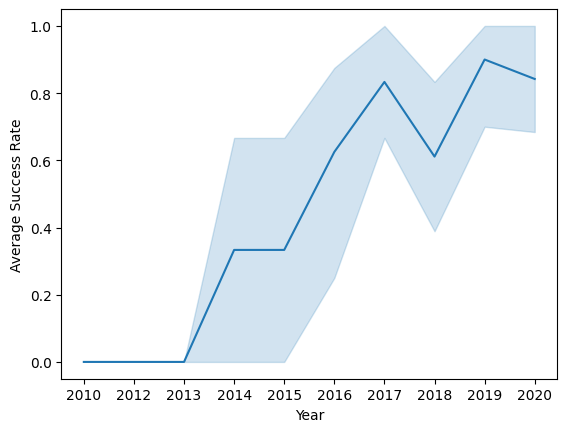

In [61]:
dfgrouped = df.groupby(['year'])['Class'].mean().reset_index()
sns.lineplot(x='year', y='Class', data=df)
plt.xlabel("Year")
plt.ylabel("Average Success Rate")
plt.show()

### FEATURE ENGINEERING

Find preliminary insights about how each important variable would affect the success rate, then select the features that will be used in success predicition for the models

In [62]:
# Features = Independent Variables
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


TASK 7 : Create dummy variables for categorical columns

In [63]:
features_one_hot = pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']])
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [64]:
features_one_hot.shape

(90, 72)

TASK 8 : Cast all numeric columns to float64

In [65]:
features_one_hot.astype('float64')
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# IV. Interactive Visualization

In [66]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b1d2319f306c485845d88260b178880d0d89ba29607ea9ac17e30aaa8fcd872c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [67]:
import folium
import wget
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

In [68]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
df=pd.read_csv(spacex_csv_file)

In [69]:
# Subset the relevant subcolumn for GEOMAP VISUALIZATION purposes
df = df[['Launch Site', 'Lat', 'Long', 'class']]

# It will grouping, and choose the FIRST ROW on the same group
launchSiteDf = df.groupby(['Launch Site'], as_index = False).first()
launchSiteDf = launchSiteDf[['Launch Site', 'Lat', 'Long']]
launchSiteDf

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [70]:
# Next, we will visualizing the given coordinates by some following steps

# FOR EXAMPLE : Create a folium map object, with an initial center location to be NASA center at TEXAS
nasaCoordinate = [29.559684888503615, -95.0830971930759]
initialMap = folium.Map(location=nasaCoordinate, zoom_start=10)

In [71]:
# After that, we will ad highlighted circle area with a text label on the specific coordinate

# Create blue circle at NASA Center's coordinate with a popup label name
circle = folium.Circle(nasaCoordinate, radius = 1000, color = '#d35400', fill = True).add_child(folium.Popup("NASA Johnson Space Center"))
marker = folium.map.Marker(
    nasaCoordinate,
    icon = DivIcon(
        icon_size = (20,20),
        icon_anchor = (0,0),
        html = '<div style="font-size: 12; color:#d35400;"><b>%s</b></div>'%'NASA JSC',
    )
)
initialMap.add_child(circle)
initialMap.add_child(marker)

TASK 1 : Mark All Launch Sites on Map

In [72]:
# Next, creating the geo-map function for each SpaceX Launch Area

SitesMap = folium.Map(nasaCoordinate, zoom_start = 3)

for index, row in launchSiteDf.iterrows():
  areaCoordinate = [row['Lat'], row['Long']]
  label = row['Launch Site']
  circle = folium.Circle(areaCoordinate, radius = 1000, color = "#d35400", fill = True).add_child(folium.Popup(label))
  marker = folium.map.Marker(
    areaCoordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % label,
        )
    )
  SitesMap.add_child(circle)
  SitesMap.add_child(marker)

SitesMap

TASK 2 : Mark the success/failed launches for each site on the map

In [73]:
marker_cluster = MarkerCluster()

In [74]:
def AssignColor(launchOutcomes):
  if launchOutcomes == 1:
    return "green"
  else:
    return "red"

df['MarkerColor'] = df['class'].apply(AssignColor) # df['MarkerColor'] = AssignColor(df['MarkerColor'])
df.tail(10)

,Launch Site,Lat,Long,class,MarkerColor
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


In [75]:
SitesMap.add_child(marker_cluster)

for index, observation in df.iterrows():
  areaCoordinate = [observation['Lat'], observation['Long']]
  marker = folium.Marker(
      areaCoordinate,
      icon = folium.Icon(
          color = observation['MarkerColor'],
          icon = 'circle'
      )
  )
  marker_cluster.add_child(marker)

SitesMap

TASK 3 : CALCULATING DISTANCES BETWEEN A LAUNCH SITE TO ITS PROXIMITIES

In [76]:
# Add MousePosition on map, to get coordinate for a mouse over a point on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mousePosition = MousePosition(
    position = 'topright',
    separator = ' Long: ',
    empty_string = 'NaN',
    lng_first = False,
    num_digits = 20,
    prefix = 'Lat:',
    lat_formatter = formatter,
    lng_formatter = formatter,
)

SitesMap.add_child(mousePosition)
SitesMap

In [77]:
# Function to calculate distance between two points on the map based on coordinates

from math import sin, cos, sqrt, atan2, radians

def DistanceCalculation(lat_1, long_1, lat_2, long_2):
  R = 6373.0 # The approximation of the earth radius (kilometers)
  lat_1 = radians(lat_1)
  long_1 = radians(long_1)
  lat_2 = radians(lat_2)
  long_2 = radians(long_2)

  distanceLong = long_2 - long_1
  distanceLat = lat_2 - lat_1

  a = sin(distanceLat / 2)**2 + cos(lat_1) * cos(lat_2) * sin(distanceLong / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  distance = R * c
  return distance

Counting the distance between launch site and **Coast Line**

Based on the MousePosition, the nearest coast line are located on the Latitude 28.56383 and Longitude -80.56802

In [78]:
# Calculating the distance

for index, observation in df.iterrows():
  distanceCoastline = DistanceCalculation(28.56383, -80.56802, observation['Lat'], observation['Long'])
  df['DistanceCoastline'] = distanceCoastline

df.head(5)

,Launch Site,Lat,Long,class,MarkerColor,DistanceCoastline
0,CCAFS LC-40,28.562302,-80.577356,0,red,0.862567
1,CCAFS LC-40,28.562302,-80.577356,0,red,0.862567
2,CCAFS LC-40,28.562302,-80.577356,0,red,0.862567
3,CCAFS LC-40,28.562302,-80.577356,0,red,0.862567
4,CCAFS LC-40,28.562302,-80.577356,0,red,0.862567


In [79]:
# Add to the maps with the line
for index, observation in df.iterrows():
  distance = "{:.2f} KM".format(float(df['DistanceCoastline'].values[-1]))
  lines = folium.PolyLine(locations = [[28.56383, -80.56802], [observation['Lat'], observation['Long']]], weight = 1).add_child(folium.Popup(distance))
  markerDistance = folium.Marker(
      [observation['Lat'], observation['Long']],
      icon = DivIcon(
          icon_size=(20,20),
          icon_anchor=(-20,0),
          #html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:.2f} KM".format(observation['DistanceCoastline']),
          html = f'<div style="font-size: 20px; color:#d35400; margin-left: 100px; white-space: nowrap;"><b>{distance}</b></div>',
      )
  )
SitesMap.add_child(markerDistance)
SitesMap.add_child(lines)

SitesMap

# V. CLASSIFICATION PREDICTION

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [81]:
# The original dataframe, with the dependent variable which is the Class 0 (for unsuccessful landings) and 1 (for successfull)
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [82]:
# Here is the encoded independent variable dataframe
x_encoded = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
x_encoded.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


TASK 1 : CREATE NUMPY ARRAY FROM THE TARGET VARIABLE

In [83]:
Y = df['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

TASK 2 : STANDARDIZE X (INDEPENDENT) DATA WITH STANDARD SCALER

In [84]:
scaler = preprocessing.StandardScaler()

x_scaled = scaler.fit_transform(x_encoded)
x_scaled[0]

array([-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, -1.57589457e+00,
       -9.73440458e-01, -1.05999788e-01, -1.05999788e-01, -6.54653671e-01,
       -1.05999788e-01, -5.51677284e-01,  3.44342023e+00, -1.85695338e-01,
       -3.33333333e-01, -1.05999788e-01, -2.42535625e-01, -4.29197538e-01,
        7.97724035e-01, -5.68796459e-01, -4.10890702e-01, -4.10890702e-01,
       -1.50755672e-01, -7.97724035e-01, -1.50755672e-01, -3.92232270e-01,
        9.43398113e+00, -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
       -1.05999788e-01, -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
       -1.05999788e-01, -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
       -1.05999788e-01, -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
       -1.05999788e-01, -1.05999788e-01, -1.05999788e-01, -1.50755672e-01,
       -1.05999788e-01, -1.05999788e-01, -1.05999788e-01, -1.05999788e-01,
       -1.05999788e-01, -1.50755672e-01, -1.05999788e-01, -1.50755672e-01,
       -1.50755672e-01, -

TASK 3 : SPLIT THE TRAIN AND TEXT DATA TO 80% TRAIN AND 20% TEST

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y, test_size = 0.2, random_state = 42)

In [86]:
y_test.shape

(18,)

TASK 4 : LOGISTIC REGRESSION WITH GRIDSEARCHCV

In [87]:
lr = LogisticRegression(random_state = 42)

In [88]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [89]:
parameters = {
    'C' : [0.01, 0.1, 1],
    'penalty' : ['l2'],
    'solver' : ['lbfgs']
}

logreg_cv = GridSearchCV(lr, param_grid = parameters, cv = 10)
logreg_cv.fit(x_train, y_train)

# Find the best parameters with it scores for the TRAIN DATA
print ("Best Parameters : ", logreg_cv.best_params_)
print ("Best Accuracy Score on TRAINING Data: ", logreg_cv.best_score_)

Best Parameters :  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy Score on TRAINING Data:  0.8035714285714285


Best Accuracy Score on TESTING Data:  1.0


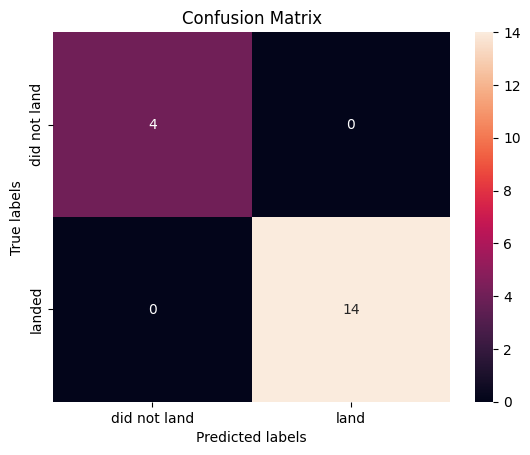

In [90]:
# Evaluate the model using TEST DATA
logreg = LogisticRegression(**logreg_cv.best_params_, random_state = 42)
logreg.fit(x_test, y_test)

bestAccuracyLog = logreg.score(x_test, y_test)
print ("Best Accuracy Score on TESTING Data: ", bestAccuracyLog)
yhat = logreg.predict(x_test)
plot_confusion_matrix(y_test, yhat)
plt.show()

TASK 6 : SUPPORT VECTOR MACHINE WITH GRIDSEARCHCV

In [91]:
svm = SVC(random_state = 42)

parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

svm_cv = GridSearchCV(svm, parameters, cv = 10)
svm_cv.fit(x_train, y_train)

# Find the best parameters with it scores for the TRAIN DATA
print ("Best Parameters : ", svm_cv.best_params_)
print ("Best Accuracy Score on TRAINING Data: ", svm_cv.best_score_)

Best Parameters :  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
Best Accuracy Score on TRAINING Data:  0.832142857142857


Best Accuracy Score on TESTING Data:  1.0


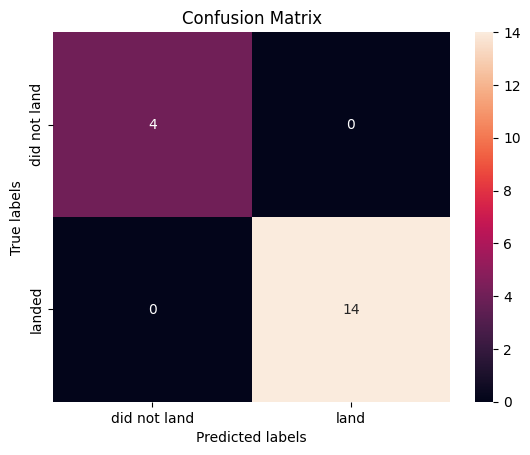

In [92]:
svm = SVC(**svm_cv.best_params_, random_state = 42)
svm.fit(x_test, y_test)

bestAccuracySVM = svm.score(x_test, y_test)
print ("Best Accuracy Score on TESTING Data: ", bestAccuracySVM)
yhat = svm.predict(x_test)
plot_confusion_matrix(y_test, yhat)
plt.show()

TASK 7 : DECISION TREE WITH GRIDSEARCHCV

In [93]:
tree = DecisionTreeClassifier(random_state = 42)

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree_cv = GridSearchCV(tree, parameters, cv = 10)

tree_cv.fit(x_train, y_train)

# Find the best parameters with it scores for the TRAIN DATA
print ("Best Parameters : ", tree_cv.best_params_)
print ("Best Accuracy Score on TRAINING Data: ", tree_cv.best_score_)

Best Parameters :  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Accuracy Score on TRAINING Data:  0.875


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

Best Accuracy Score on TESTING Data:  1.0


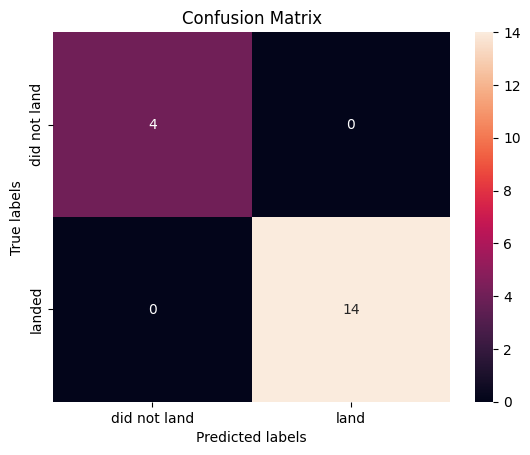

In [94]:
tree = DecisionTreeClassifier(**tree_cv.best_params_, random_state = 42)

tree.fit(x_test, y_test)

bestAccuracyTree = tree.score(x_test, y_test)
print ("Best Accuracy Score on TESTING Data: ", bestAccuracyTree)
yhat = tree.predict(x_test)
plot_confusion_matrix(y_test, yhat)

TASK 8 : K NEAREST NEIGHOURS WITH GRIDSEARCHCV

In [95]:
KNN = KNeighborsClassifier()

parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_cv = GridSearchCV(KNN, param_grid=parameters, cv = 10)

knn_cv.fit(x_train, y_train)

print ("Best Parameters : ", knn_cv.best_params_)
print ("Best Accuracy Score on TRAINING Data: ", knn_cv.best_score_)

Best Parameters :  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
Best Accuracy Score on TRAINING Data:  0.8446428571428569


Best Accuracy Score on TESTING Data:  0.9444444444444444


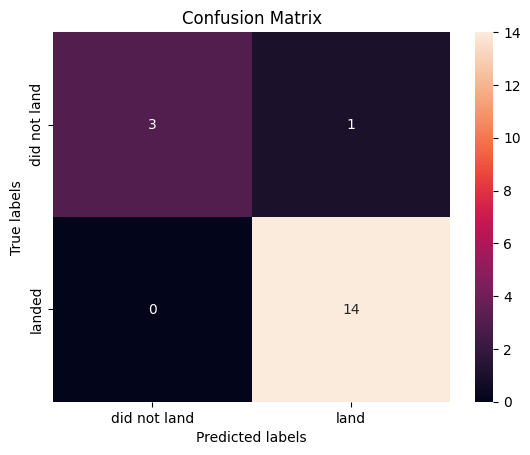

In [96]:
KNN = KNeighborsClassifier(**knn_cv.best_params_)

KNN.fit(x_test, y_test)

bestAccuracyKNN = KNN.score(x_test, y_test)
print ("Best Accuracy Score on TESTING Data: ", bestAccuracyKNN)
yhat = KNN.predict(x_test)
plot_confusion_matrix(y_test, yhat)

Visualization of Each Model's Accuracy to find the best one

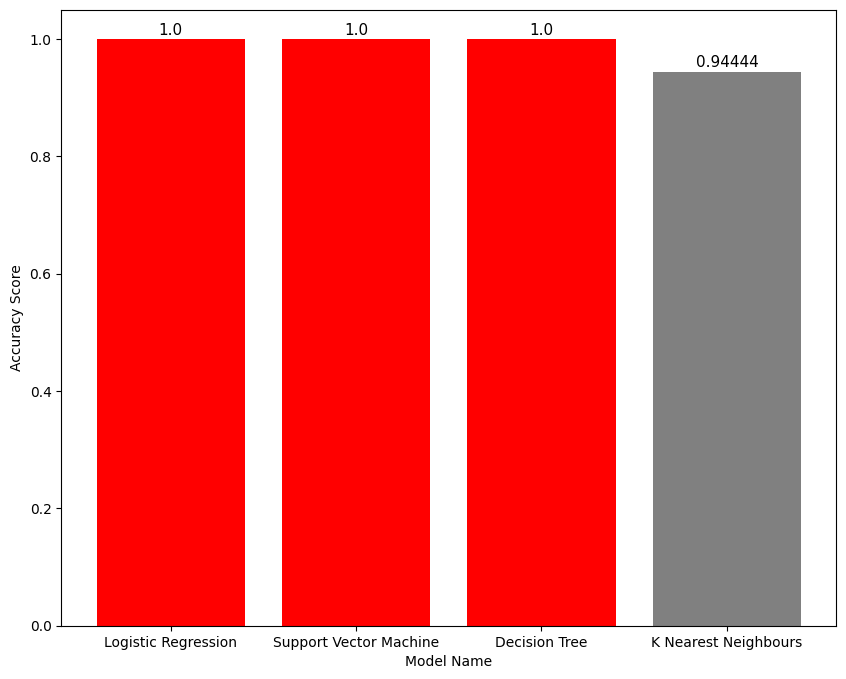

In [97]:
model = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'K Nearest Neighbours']
accuracy = [bestAccuracyLog, bestAccuracySVM, bestAccuracyTree, bestAccuracyKNN]

dfviz = pd.DataFrame({'Model':model, 'Accuracy':accuracy})
dfviz = dfviz.sort_values(by='Accuracy', ascending=False)

colors = ['red' if val == dfviz['Accuracy'].max() else 'gray' for val in dfviz['Accuracy']]

plt.figure(figsize = (10,8))
plt.bar(dfviz['Model'], dfviz['Accuracy'], color = colors)
for i, val in enumerate(dfviz['Accuracy']):
  plt.text(i, val + 0.008, str(round(val,5)), ha = 'center', size = 11)
plt.xlabel("Model Name")
plt.ylabel("Accuracy Score")
plt.show()